Check packages

In [118]:
using Pkg
Pkg.activate("..");
Pkg.status()
Pkg.instantiate()
Pkg.update()

Makie.inline!(true)

Status `E:\dev\ConcreteExplorer\Project.toml`
  [acfe5cae] AsapSections v0.1.0 `https://github.com/keithjlee/AsapSections#main`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
  [59287772] Formatting v0.4.2
  [e9467ef8] GLMakie v0.9.3
  [682c06a0] JSON v0.21.4
  [ee78f7c6] Makie v0.20.2
  [90137ffa] StaticArrays v1.8.0
  [10745b16] Statistics v1.9.0

  Activating project at `e:\dev\ConcreteExplorer`


    Updating registry at `C:\Users\pitipatw\.julia\registries\General.toml`


    Updating git-repo `https://github.com/keithjlee/AsapSections`


  No Changes to `E:\dev\ConcreteExplorer\Project.toml`
  No Changes to `E:\dev\ConcreteExplorer\Manifest.toml`


true

Load required packages

In [119]:
using AsapSections
using Makie, GLMakie
using CSV, DataFrames
using Formatting
using Statistics

Load Jonathan Broyles scraped data.

In [120]:
dataset_Broyles = CSV.read("Compiled Concrete EPD Data Revised 11_06_2023.csv", DataFrame);
names(dataset_Broyles)


97-element Vector{String}:
 "Company"
 "Company Location - Street"
 "Company Location - City"
 "Company Location - State"
 "Company Location - Zip"
 "Plant"
 "Plant Location - Street"
 "Plant Location - City"
 "Plant Location - State"
 "Plant Location - Zip"
 ⋮
 "Primary LCI Data Source for Portland Limestone Cement"
 "Primary LCI Data Source for Propane"
 "Primary LCI Data Source for Rail Transport"
 "Primary LCI Data Source for Ship Transport"
 "Primary LCI Data Source for Silica Fume"
 "Primary LCI Data Source for Slag Cement"
 "Primary LCI Data Source for Truck Transport"
 "Primary LCI Data Source for Any Other Item"
 "EPD Source Link"

Visualize the dataset.

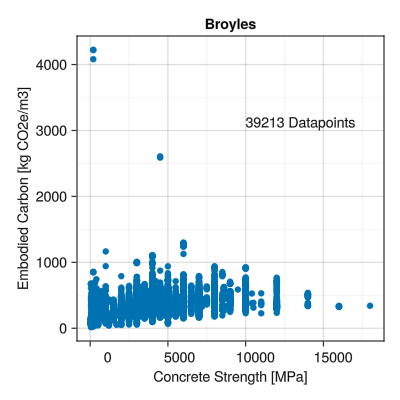

In [121]:
fc′_Broyles_psi = dataset_Broyles[!,"Concrete Compressive Strength (psi)"]
ec_Broyles = dataset_Broyles[!, "A1-A3 Global Warming Potential (kg CO2-eq)"]

#number formatting
printx(x,N) = sprintf1("%10.$(N)f",x)


f1 = Figure(size = (400,400))
ax1 = Axis(f1[1,1],
title = "Broyles",
xlabel = "Concrete Strength [MPa]",
ylabel = "Embodied Carbon [kg CO2e/m3]",

xminorticks = 0:2500:20000,
xminorgridvisible = true,
yminorticks = 0:500:4000,
yminorgridvisible = true,
xtickformat =  x -> printx.(x,0))

scatter!(ax1, fc′_Broyles_psi, ec_Broyles)
text!(ax1, string(length(fc′_Broyles_psi)) *" Datapoints", position=(10000,3000))
f1


Here, we have 39213 datapoints similar to the paper, but there are some points that suspiciously high.<br> 
Therefore, we will remove those points.

In [122]:
# filter = ec_Broyles .> 800;
# deleteat!(dataset_Broyles, filter);
fc′_Broyles_psi = dataset_Broyles[!,"Concrete Compressive Strength (psi)"];
ec_Broyles = dataset_Broyles[!, "A1-A3 Global Warming Potential (kg CO2-eq)"];
#convert to MPa
fc′_Broyles_MPa = fc′_Broyles_psi*0.00689476;


Then, re-plot again.

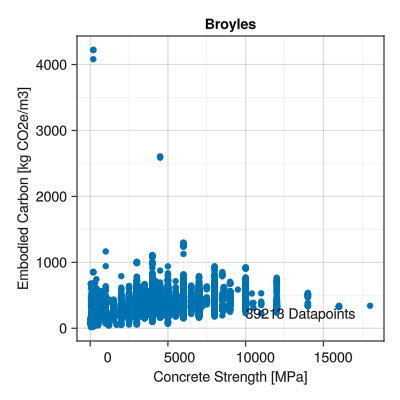

In [123]:
f2 = Figure(size = (400,400))
ax2 = Axis(f2[1,1],
title = "Broyles",
xlabel = "Concrete Strength [MPa]",
ylabel = "Embodied Carbon [kg CO2e/m3]",

xminorticks = 0:2500:20000,
xminorgridvisible = true,
yminorticks = 0:500:4000,
yminorgridvisible = true,
xtickformat =  x -> printx.(x,0))

scatter!(ax2, fc′_Broyles_psi, ec_Broyles)
text!(ax2, string(length(fc′_Broyles_psi)) *" Datapoints", position=(10000,100))


f2

Next, we will group the data as shown in the paper.

In [124]:
#define groups as done in the paper
label = Vector{Int64}(undef, length(fc′_Broyles_MPa))
for i in eachindex(fc′_Broyles_MPa)
    fc′ = fc′_Broyles_psi[i]
    if fc′ <2000
        label[i] = 1
    elseif fc′< 3000
        label[i] = 2
    elseif fc′< 4000
        label[i] = 3
    elseif fc′< 5000
        label[i] = 4
    elseif fc′< 6000
        label[i] = 5
    elseif fc′< 8000
        label[i] = 6
    elseif fc′< 10000
        label[i] = 7
    elseif fc′< 12000
        label[i] = 8
    else
        label[i] = 9
    end
end

# add the label into the dataset. 
dataset_Broyles[!,"Label"] = label;

Now, we plot the data again with the new labels.

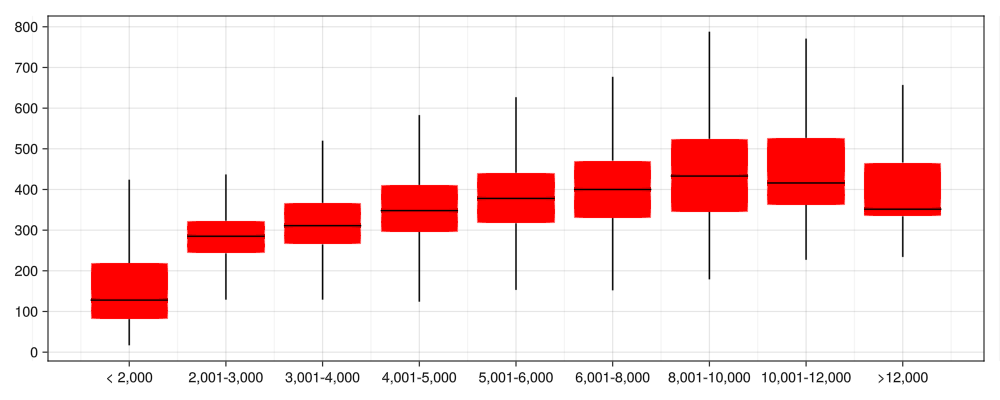

In [125]:
f3 = Figure(size = (1000,400))

ax3 = Axis(f3[1,1],
xticks=  1:9,
xminorgridvisible = true,
xtickformat =  x -> ["< 2,000",
"2,001-3,000",
"3,001-4,000",
"4,001-5,000",
"5,001-6,000",
"6,001-8,000",
"8,001-10,000",
"10,001-12,000",
">12,000"][Int.(x)],
yticks = 0:100:800)
boxplot!(ax3,label,ec_Broyles, color = :red, show_outliers = false)

# ax4 = Axis(f3[2,1],
# xticks=  1:9,
# xminorgridvisible = true,
# xtickformat =  x -> ["< 2,000",
# "2,001-3,000",
# "3,001-4,000",
# "4,001-5,000",
# "5,001-6,000",
# "6,001-8,000",
# "8,001-10,000",
# "10,001-12,000",
# ">12,000"][Int.(x)],
# yticks = 0:100:800)
# violin!(ax4,label,ec_Broyles, color = :red)

f3


(The paper)

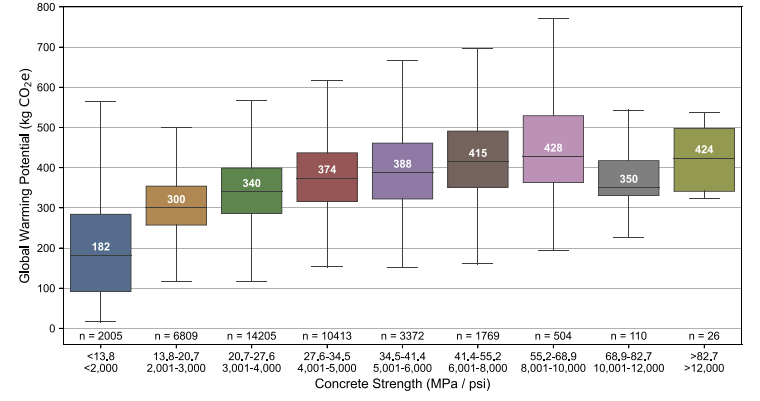

We will work on 4 batches. 
0. All of the dataset, grouped with the same labels.
1. Median line
2. Maximum line
3. Minimum line
4. A company line (Select one)

Check how many datapoint each company has.

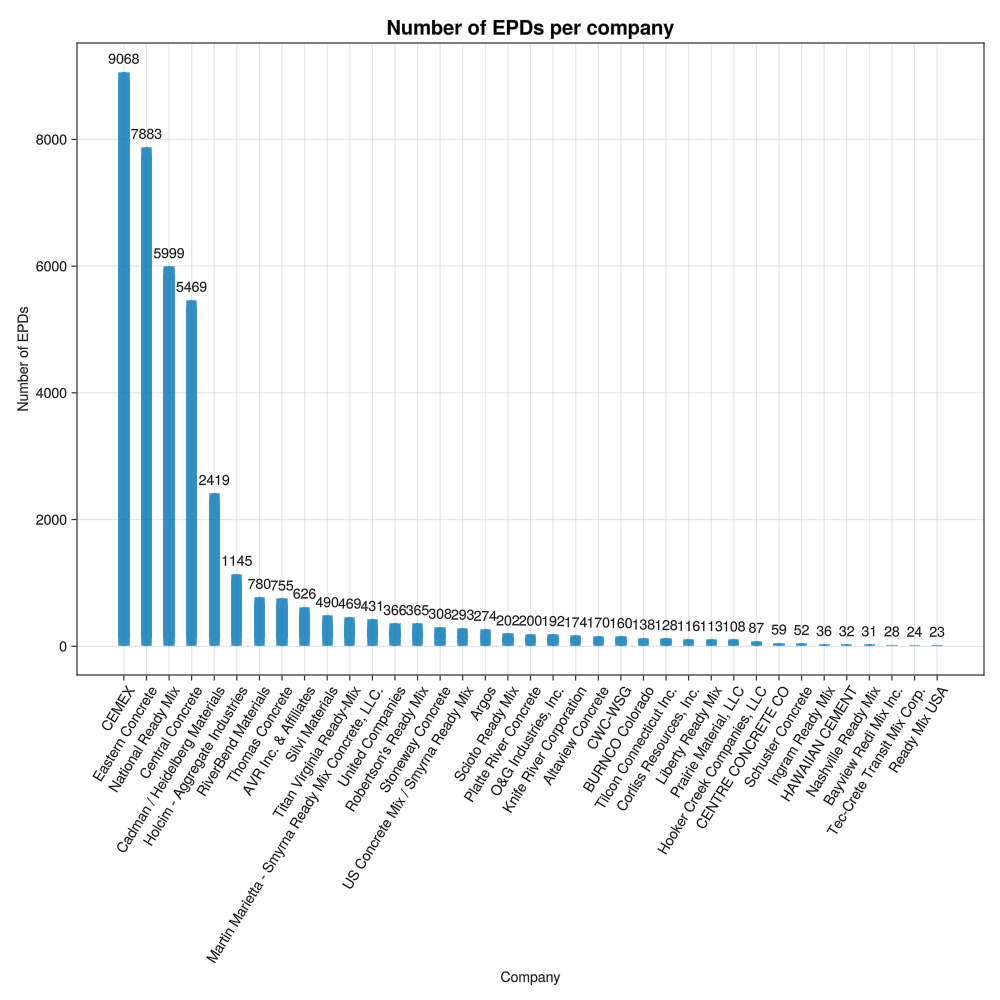

In [192]:
company_names = unique(dataset_Broyles[!, :Company])
company_n_EPDs = Dict{String, Int64}()
n_company = length(company_names)
for i in company_names
    company_n_EPDs[i] = size(dataset_Broyles[dataset_Broyles.Company .== i,:],1)
end
number_of_EPDs = [ company_n_EPDs[i] for i in company_names]
perm = sortperm(number_of_EPDs, rev= true)
company_names = company_names[perm]

f_company = Figure(size = (1000,1000))
a_company = Axis(f_company[1,1], xticks = (1:n_company, company_names), xticklabelrotation = 45, 
title = "Number of EPDs per company",
titlesize = 20, 
xlabel = "Company",
ylabel = "Number of EPDs")
barplot!(a_company,
   1:n_company,         
   number_of_EPDs[perm],
   bar_labels = number_of_EPDs[perm],
   gap = 0.5)

f_company

In [188]:
company_n_EPDs["CEMEX"]

9068

Let's create those lines


In [193]:
line1 = Vector{Float64}(undef, 9);
line2 = Vector{Float64}(undef, 9);
line3 = Vector{Float64}(undef, 9);


In [217]:
company_name = "CEMEX"
for i in 1:9
    sub_dataset = dataset_Broyles[dataset_Broyles.Label .== i, "A1-A3 Global Warming Potential (kg CO2-eq)"]
    first_quantile  = quantile!(sub_dataset, 0.25)
    second_quantile = quantile!(sub_dataset, 0.50)
    third_quantile  = quantile!(sub_dataset, 0.75)
    IQR = third_quantile - first_quantile
    line1[i] = second_quantile
    line2[i] = third_quantile + 1.5*IQR
    line3[i] = clamp(first_quantile - 1.5*IQR, minimum(sub_dataset), Inf)
    # line3[i] = quantile!(sub_dataset, 0)
    
    company_dataset = dataset_Broyles[dataset_Broyles.Company .== company_name, :]
    line4[i] = median(company_dataset[company_dataset.Label .== i,"A1-A3 Global Warming Potential (kg CO2-eq)"])
end


Let's check those lines out in a plot on the total dataset.

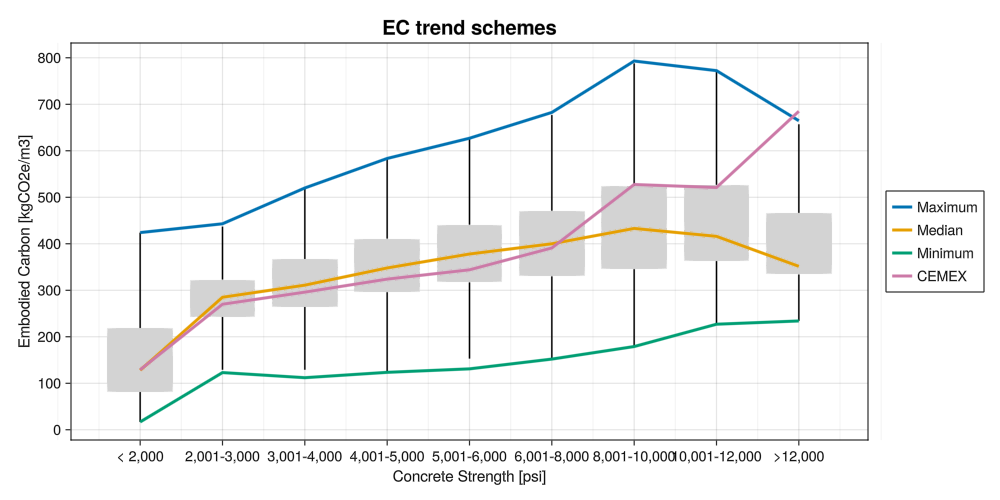

In [242]:
f4 = Figure(size = (1000,500))
ax4 = Axis(f4[1,1],
title = "EC trend schemes", titlesize = 20,
xlabel = "Concrete Strength [psi]",
xlabelsize = 15,
xticks=  1:9,
xminorgridvisible = true,
xtickformat =  x -> ["< 2,000",
"2,001-3,000",
"3,001-4,000",
"4,001-5,000",
"5,001-6,000",
"6,001-8,000",
"8,001-10,000",
"10,001-12,000",
">12,000"][Int.(x)],
ylabel = "Embodied Carbon [kgCO2e/m3]",
ylabelsize = 15,
yticks = 0:100:800)

#plot the previous data, greyed out
boxplot!(ax4,label,ec_Broyles, color = colorant"#D3D3D3", show_outliers = false, show_median=false)

lines!(ax4, 1:9,line2, label = "Maximum", linewidth = 3)
lines!(ax4, 1:9,line1, label = "Median", linewidth = 3)
lines!(ax4, 1:9,line3, label = "Minimum", linewidth = 3)
lines!(ax4, 1:9,line4, label = company_name, linewidth = 3)
Legend(f4[1,2],ax4)
f4


